In [2]:
import os, sys
os.environ["MKL_NUM_THREADS"]='12' 
os.environ["NUMEXPR_NUM_THREADS"]='12'
os.environ["OMP_NUM_THREADS"]='12'

import matplotlib.pyplot as plt
import numpy as np
from tqdm import trange, tqdm_notebook
from Datasets import LatentDynamics, Observations, SSM
from Inferences import SMC
from DDC import Features, DDC, DDCSSM, Regressors
import Utils
from copy import deepcopy
from collections import OrderedDict
import torch
from settings import CTX
import matplotlib as mpl

if sys.version_info[0] > 2:
    from importlib import reload

%matplotlib inline

In [4]:

SMALL_SIZE = 8
MEDIUM_SIZE = 12
BIGGER_SIZE = 14

plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

/nfs/nhome/live/kevinli/Code/ddc_ssm/Datasets/LatentDynamics.py:688: RuntimeWarning: divide by zero encountered in log
  self.ps["m"] = torch.tensor( np.log(p/(1-p)), **CTX)


Text(0.5, 0, 'time')

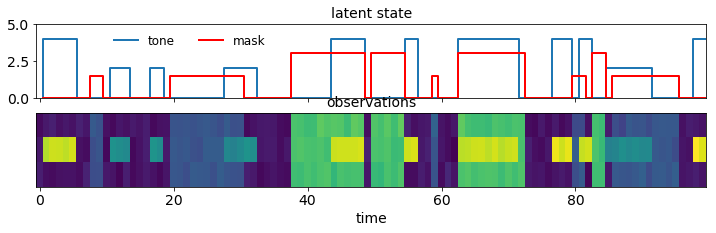

In [5]:
np.random.seed(1)
torch.manual_seed(2)

Dx = 3
D = Dx+2
init_noise_std = 0.0

Z = LatentDynamics.FactorialHMM([0.0,0.2,0.0,0.2]*1+[0.0],2)
X = Observations.OccludedToneObservation([0.05]*Dx)
true_model = SSM.StateSpaceModel(Z,X,init_noise_std, init_fun=lambda n: torch.zeros(n,D, **CTX))


'''
infer_model.ps[3:] += np.random.randn(*infer_model.ps[3:].shape)*1
latent_idx = infer_model.pp.idxs_and_shapes['lat'][0]
#infer_model.ps[latent_idx]=true_model.ps[latent_idx]
infer_model.sync_ps()
'''

T = 100
nchain = 1
data = true_model.sample(T,1)
fig,axes = plt.subplots(2,1, figsize=(12,3), sharex=True)

ax = axes[0]
ax.step(np.arange(T)+0.5, data["zt"][:,0,1].cpu().numpy()*2, lw=2, label="tone")
ax.step(np.arange(T)+0.5, np.clip(data["zt"][:,0,3].cpu().numpy()*2-0.5,0,3), lw=2, color="r", label="mask")
ax.set_ylim(0,5)
ax.set_title("latent state")
ax.legend(frameon=False, ncol=2, loc="upper left", bbox_to_anchor=(0.1,1.0))
ax = axes[1]
im = ax.imshow(data["xt"].cpu().numpy()[:,0,:].T, aspect="auto")
ax.set_yticks([])
ax.set_title("observations")
ax.set_xlabel("time")
#fig.savefig("figs/tone_example.pdf")

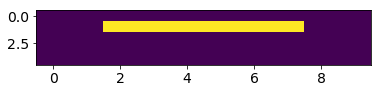

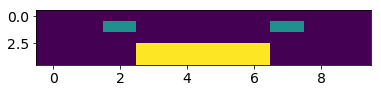

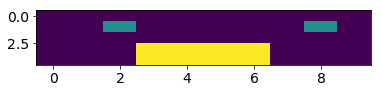

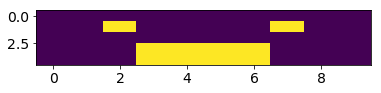

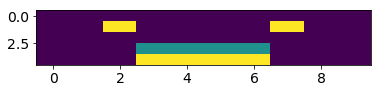

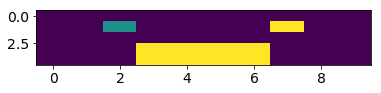

In [6]:
nexp =6
manual_data = torch.zeros(20, nexp, D, **CTX)

counter = 0


# 0  no mask
manual_data[:,counter,1] = torch.cat([
                         torch.zeros(4), torch.ones(12)*1,torch.zeros(4)
                        ])[:T]

counter +=1 


# 1  masked continuation

manual_data[:,counter,1] = torch.tensor([0]*4+[1]*2+[0]*8+[1]*2+[0]*4)

manual_data[:,counter,-2] = torch.cat([
                         torch.zeros(6), torch.ones(8)*2, torch.zeros(6), 
                        ])[:T]
manual_data[:,counter,-1] = torch.tensor([0]*6+[2]*8+[0]*6)

counter +=1 

# 2  masked continuation delayed supression

manual_data[:,counter,1] = torch.tensor([0]*4+[1]*2+[0]*9+[1]*2+[0]*3)

manual_data[:,counter,-2] = torch.cat([torch.zeros(6), torch.ones(8)*2, torch.zeros(6)])[:T]
manual_data[:,counter,-1] = torch.tensor([0]*6+[2]*8+[0]*6)

counter +=1 

# 3  high tone, lower

manual_data[:,counter,1] = torch.tensor([0]*4+[2]*2+[0]*8+[2]*2+[0]*4)

manual_data[:,counter,-2] = torch.cat([
                         torch.zeros(6), torch.ones(8)*2, torch.zeros(6), 
                        ])[:T]
manual_data[:,counter,-1] = torch.tensor([0]*6+[2]*8+[0]*6)

counter +=1 

# 4  high tone, low mask

manual_data[:,counter,1] = torch.cat([
                         torch.zeros(4), torch.ones(2)*2,torch.zeros(8), torch.ones(2)*2,torch.zeros(4)
                        ])[:T]

manual_data[:,counter,-2] = torch.cat([
                         torch.zeros(6), torch.ones(8)*1, torch.zeros(6), 
                        ])[:T]
manual_data[:,counter,-1] = torch.tensor([0]*6+[2]*8+[0]*6)

counter +=1 

# 5  tone changes


manual_data[:,counter,1] = torch.cat([torch.zeros(4),torch.ones(2),torch.zeros(8),
                                      torch.ones(2)*2,torch.zeros(4)])[:T]

manual_data[:,counter,-2] = torch.cat([
                         torch.zeros(6), torch.ones(8)*2, torch.zeros(6), 
                        ])[:T]
manual_data[:,counter,-1] = torch.tensor([0]*6+[2]*8+[0]*6)
     

'''
counter +=1 

manual_data[:,counter,1] = torch.cat([torch.zeros(4),torch.ones(12)*2,torch.zeros(4)])[:T]

manual_data[:,counter,-2] = torch.tensor([0]*6+[2,1]*4+[0]*6)
manual_data[:,counter,-1] = torch.tensor([0]*6+[2]*8+[0]*6)


counter +=1 

manual_data[:,counter,1] = torch.cat([torch.zeros(4),torch.ones(12),torch.zeros(4)])[:T]
manual_data[:,counter,-2] = torch.tensor([0]*6+[2,2]*4+[0]*6)
manual_data[:,counter,-1] = torch.tensor([0]*6+[1]*8+[0]*6)


counter +=1 

manual_data[:,counter,1] = torch.cat([torch.zeros(4),torch.ones(12),torch.zeros(4)])[:T]

manual_data[:,counter,-2] = torch.tensor([0]*6+[2,2]*4+[0]*6)
manual_data[:,counter,-1] = torch.tensor([0]*6+[2]*8+[0]*6)

counter +=1 
'''
#manual_data[:,counter,-1] = torch.tensor([0]*6+[2,1]*4+[0]*6, **CTX )

# high tone low noise

#  mask


manual_data = manual_data[::2]

for i in range(nexp):
    plt.figure(figsize=(6,1))
    plt.imshow(manual_data[:,i,:].t().cpu().numpy(), aspect="auto")

In [7]:
M = 15
init_std = 1.0
map_z = Features.ContinuousFeature(M, true_model.latent.D, init_std, [-1, 3], lam=1e-6)

map_zz = Features.ContinuousFeature(M, true_model.latent.D*2, init_std, [-1, 3], lam=1e-6)
map_x = Features.ContinuousFeature(10, true_model.observation.D, init_std, [-1, 3], lam=1e-6)

fs ={ "xt":   map_x,
      "zt":   deepcopy(map_z),
      "zt-1": deepcopy(map_z)
}

fs_pair ={ 
      "xt": map_x,
      "zt":   deepcopy(map_z),
      "zt-1": deepcopy(map_z),
      "zzt": map_zz,
}

T_train = 80
T_fall  = 10
T_test  = 10
T = T_train + T_test + T_fall

torch.manual_seed(3)

nsleep = 20000
nwake = nexp
test_data = {}

test_data["zt"] = torch.cat([torch.zeros(T_train,nexp,D,**CTX),manual_data,torch.zeros(T_fall,nexp,D,**CTX)], 0)
test_data["zt-1"] = test_data["zt"]
test_data["xt"] = true_model.observation.sample(test_data["zt"])

In [8]:
def samples_to_hist(samples, weights, edges):
    
    # length, nchain and sample size
    T, C, N = weights.shape
    E = len(edges)-1

    posts = np.zeros((T, C, E))
    for ci in range(C):
        for t in range(T):
            posts[t,ci] = np.histogram(samples[t,ci,:,0],
                                          weights=weights[t,ci,:],bins=edges, 
                                       
                                          normed=True)[0]
    return posts

samples, weights = SMC.filtering_bootstrap(true_model, test_data["xt"][:,:,:], nsample=3000)
pf_pm = torch.sum(weights[...,None] * samples, -2).cpu().detach().numpy()

In [9]:

drd_dict = {}
ddcs = OrderedDict()

reg = Regressors.LinearRegressor(fs, lam=1e-5, tensor_op='*')
reg_pair = Regressors.LinearRegressor(fs_pair, lam=1e-5, tensor_op='*')

fun_data = torch.rand(5000,D, **CTX)*3-1.5
reg.fs["zt"].learn_fun("Ez",   fun_data, fun_data)
reg.fs["zt-1"].learn_fun("Ez", fun_data, fun_data)


# ddcs["drd_fil"] = DDCSSM.DistributionRegression(true_model, reg, nsleep=nsleep, 
#                                     nwake=nwake, plastic=[True,True], stationary=False, 
#                                                 smoothing=True, nretain=None)

ddcs["drd_pair"] = DDCSSM.DecayDistributionRegression([1]*10, true_model, reg_pair, nsleep=nsleep, 
                                    nwake=nwake, plastic=[True,True], stationary=False, 
                                                        nretain=None, 
                                                        look_back=10)



ps = OrderedDict()

for dn in ddcs:
    
    ddc = ddcs[dn]
    ddc.initialise(test_data["xt"][0])
    
for t in tqdm_notebook(range(1,T+1)):

    for dn, ddc in ddcs.items():
        
        if t <= T_train:
            ddc.sleep_train_test()
        else:
            ddc.sleep_test()
        #print(dict([(k[-2:], v.cpu().numpy().round(3)) for k,v in ddc.reg.R2s.items()]))
        ddc.reg.R2s={}
        if t < T:
            ddc.propagate(test_data["xt"][t])
            ddc.reg.R2s={}

for dn, ddc in ddcs.items():
    if ddc.smoothing==True:
        ddc.smooth()     
    
for dn in ddcs:

    ddcs[dn].finalise()

In [10]:
from Utils import decode
import itertools

support_2 = np.array(list(itertools.product([0,1,2],repeat=2)))
support = np.zeros(support_2.shape[:1] + (5,))
support[:,[1,3]] = support_2

f_W = ddc.reg.fs["zt"].W.cpu().numpy()
f_b = ddc.reg.fs["zt"].b.cpu().numpy()


p_tone_t = np.full((nexp,(T_test)*4,10), np.nan)
p_mask_t = np.full((nexp,(T_test)*4,10), np.nan)

for ei in range(nexp):
    
    for t_real in range(T_test):
        
        f = ddc.sleep_history["fzzt"][T_train+t_real]
        # joint over tone and mask
        joint_m = ddc.wake_history["mzzt_x1:t"][T_train+t_real] 
        for t in range(t_real+1):    

            # projecting joint feature at time t to singletons at t
            y = ddc.reg.fs["zt"](torch.tensor(ddc.sleep_history["zt"][T_train+t], **CTX)).cpu().numpy()
            W = np.linalg.solve( f.T @ f, f.T @ y)
            marginal_m = joint_m @ W

            def phi_fun(x):
                return np.tanh(x[None]@f_W + f_b)[0]


            # store probabilities for each experiment

            joint_p = decode(marginal_m[ei], phi_fun, support)
            p_tone_t[ei,4*t_real:4*t_real+3,t] = joint_p.reshape(3,3).sum(1)[::-1]
            p_mask_t[ei,4*t_real:4*t_real+3,t] = joint_p.reshape(3,3).sum(0)[::-1]

In [11]:
ddcs["drd_pair"].wake_history.data["Ezt-0_x1:t"] = ddcs["drd_pair"].wake_history.data["Ezt_x1:t"]

In [12]:
test_z = test_data["zt"].cpu().numpy()
test_x = test_data["xt"].cpu().numpy()
ddc_keys = []
ddc_means = []
nlag = 11
for i in range(0, nlag):
    ddc_keys += "Ezt-%d_x1:t"%i,
    ddc_means += np.r_[ddcs["drd_pair"].wake_history.data["Ezt-%d_x1:t"%i].clip(0,2),
                           np.full((i, nexp, D),np.nan)],

noise_x = true_model.observation.ps["noise_std"].exp()[0].cpu().numpy()
# np.savez("figs/tone_cool_data_n%02d"%(np.round(noise_x*100)), test_z=test_z, T_train=T_train, T_fall=T_fall,
#         nexp=nexp, nlag=nlag, test_x=test_x, ddc_keys=ddc_keys, ddc_means=ddc_means,
#         pf_pm=pf_pm, T_test=T_test,p_tone_t=p_tone_t, samples_t=samples_t, distances=distances,
#         nsample=nsample, p_mask_t=p_mask_t)

In [13]:
# locals().update(dict(np.load("figs/tone_cool_data_n%02d.npz"%(np.round(noise_x*100)))))

Text(0, 0.5, 'probability')

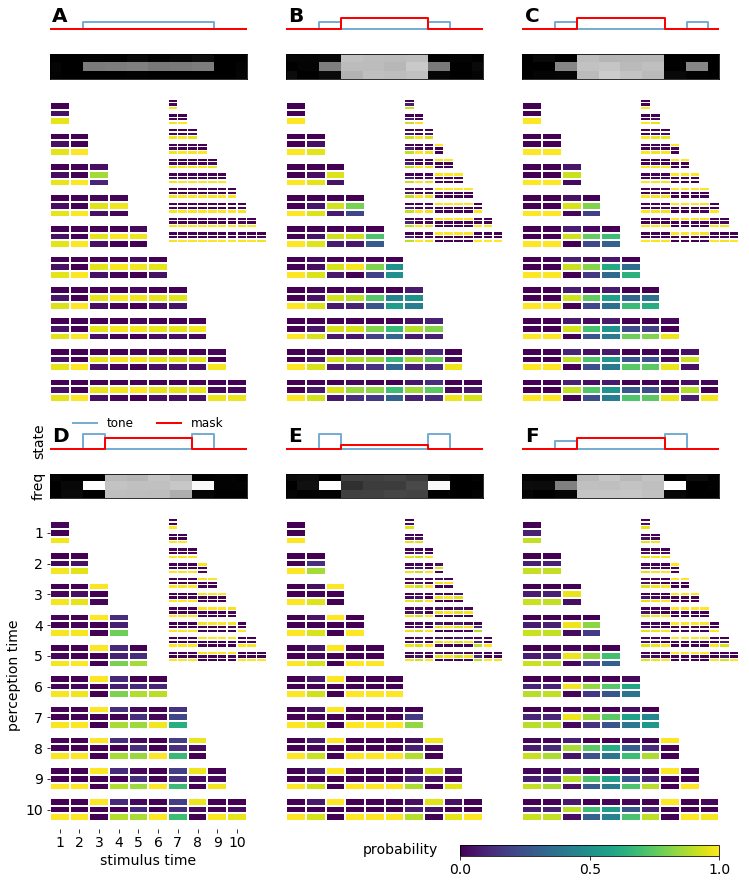

In [14]:

from matplotlib.patches import ConnectionPatch

ddcs_hists = dict(zip(ddc_keys, ddc_means))
T = T_train+T_fall + T_test
height_ratios = np.array([0.05,0.07,0.88]*2)
ddc_hists = dict(zip(ddc_keys, ddc_means))
fig, axes = plt.subplots(6,nexp//2,figsize=(2*nexp,15), sharex=False, 
                         gridspec_kw=dict(height_ratios=height_ratios))

SMALL_SIZE = 8
MEDIUM_SIZE = 12
BIGGER_SIZE = 14

plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

ncols = axes.shape[-1]
for batch_idx in range(nexp):
    dim_idx = 1
    
    row = (batch_idx//ncols)*3
    col = int(batch_idx % ncols)
    ax = axes[row, col]
    ax.step(np.arange(T)+0.5,test_z[:,batch_idx,dim_idx], label="tone", lw=2, alpha=0.6)
    ax.step(np.arange(T)+0.5,(test_z[:,batch_idx,-2]-0.5).clip(0,2), label="mask", lw=2, color="red")
    ax.set_yticks([])
    ax.set_xticks([])
    ax.set_ylim(-0.2,2.2)
    ax.set_xlim(T_train,T-1-T_fall)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.set_xticks([])
    ax.text(0.1+T_train,1.0,chr(65+batch_idx), fontsize=20, fontweight="heavy")
    
    if batch_idx == 3:
        ax.legend(frameon=False, ncol=2, bbox_to_anchor=[0.5,2.5], loc="upper center")
        
        
    row = (batch_idx//ncols)*3+1
    col = int(batch_idx % ncols)
    ax = axes[row, col]
    ax.imshow(test_x[:,batch_idx,:].T, aspect="auto", vmin=0, vmax=2, cmap="gray")
    ax.set_yticks([])
    ax.set_xlim(T_train,T-1-T_fall)

    ax.set_xticks([])
    #ax.plot(pf_pm[:,batch_idx,dim_idx], ":", label="pf")
    #axes[d].plot(static.test_history.data["Ezt_x1:t"][:,batch_idx,d], label="sta")
    ddc_rec_m =ddc_hists["Ezt-0_x1:t"][:,batch_idx,dim_idx].clip(0,2)

    im = [pf_pm[:,batch_idx,dim_idx],ddc_rec_m]
    for i in range(1,nlag,1):
        im += ddc_hists["Ezt-%d_x1:t"%i][:,batch_idx,dim_idx].clip(0,2),
        
    row = (batch_idx//ncols)*3+2
    ax = axes[row, col]

    
    im = ax.pcolormesh(range(T_test+1), range(T_test*4+1)[::-1], p_tone_t[batch_idx], 
                       cmap="viridis", edgecolor="w")
    
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    #im = in_ax.imshow(im, aspect="auto", vmin=0, vmax=2)
    ax.set_yticks([])
    ax.set_xticks([])
    
    
    in_ax = ax.inset_axes([0.6,0.53,0.5,0.48])
    in_ax.pcolormesh(range(T_test+1), range(T_test*4+1)[::-1], p_mask_t[batch_idx], 
                   cmap="viridis", edgecolor="w", linewidth=0.3)
    
    in_ax.spines['top'].set_visible(False)
    in_ax.spines['right'].set_visible(False)
    in_ax.spines['bottom'].set_visible(False)
    in_ax.spines['left'].set_visible(False)
    #im = in_ax.imshow(im, aspect="auto", vmin=0, vmax=2)
    in_ax.set_yticks([])
    in_ax.set_xticks([])
        
#     ax.plot([2,2],[0.5,40-8], ":C0")
#     ax.plot([8,8],[0.5,40-32], ":C0")
    
#     ax.plot([3,3],[0.5,40-12], ":r")
#     ax.plot([7,7],[0.5,40-28], ":r")
    

axes[-3,0].set_ylabel("state")
axes[-2,0].set_ylabel("freq")
# axes[-1,0].set_yticks(range(12))
# axes[-1,0].set_yticklabels(["exact"] + ["%d"%i if i % 5 == 0 else "" for i in range(11)],
#                           fontsize=13)
# axes[-1,0].set_ylabel(r"$\tau$", labelpad=-20)

# axes[-1,0].set_xticks(range(T_train,T-T_fall,5))
# axes[-1,0].set_xticklabels(range(0,T-T_train-T_fall,5))
ax = axes[-1,0]
axes[-1,0].set_xlabel("stimulus time")
axes[-1,0].set_yticks(np.arange(2.5,42.5,4))
axes[-1,0].set_xticks(np.arange(0.5,10.5,1))
ax.set_xticklabels(range(1,11,1))
ax.set_yticklabels(range(10,0,-1))
axes[-1,0].set_ylabel("perception time")


# fig.tight_layout(pad=0.5)
cbaxes = fig.add_axes([0.6, 0.1, 0.3, 0.01]) 
cb = plt.colorbar(im, cax = cbaxes,orientation="horizontal", ticks=[0,0.5,1])  
cbaxes.set_ylabel("probability", rotation=0, va="center",labelpad=60)

# fig.savefig("figs/tones_cool_n%02d.pdf"%(np.round(noise_x*100)), pad_inches=0,
#            bbox_inches = 'tight')